<a href="https://colab.research.google.com/github/donbcolab/composable_vlms/blob/main/notebooks/landingai_shark_video_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landing AI - shark video detection

Can you write a program to check if each person is wearing a helmet? First detect all the people in the image, then detect the helmets, check whether or not a person is wearing a helmet if the helmet is on the worker. Return a dictionary with the count of people with helmets and people without helmets.

Visualize the result

## Creating instructions

Extract frames from the video '/home/user/tmp2dwnlz5z.mp4' at 1 frame per second using the 'extract_frames' tool.
For each extracted frame, use the 'owl_v2' tool with the prompt 'surfboard, shark' to detect surfboards and sharks in the frame.
For each frame, if both surfboards and sharks are detected, calculate the distance between each shark and the nearest surfboard using the 'closest_box_distance' tool. Assume 30 pixels is 1 meter.
Draw a green line between each shark and the nearest surfboard, and add the distance in meters. If the distance is within 10 meters, make the line red.
Save the modified frames as a video named 'output.mp4' using the 'save_video' tool.

## Retrieving tools

'extract_frames' extracts frames from a video which can be a file path or youtube link, returns a list of tuples (frame, timestamp), where timestamp is the relative time in seconds where the frame was captured. The frame is a numpy array.
'save_video' is a utility function that saves a list of frames as a mp4 video file on disk.
'owl_v2' is a tool that can detect and count multiple objects given a text prompt such as category names or referring expressions. The categories in text prompt are separated by commas. It returns a list of bounding boxes with normalized coordinates, label names and associated probability scores.
'ocr' extracts text from an image. It returns a list of detected text, bounding boxes with normalized coordinates, and confidence scores. The results are sorted from top-left to bottom right.
'closest_box_distance' calculates the closest distance between two bounding boxes.
'closest_mask_distance' calculates the closest distance between two masks.
'save_image' is a utility function that saves an image to a file path.

In [ ]:
!pip install -qU vision_agent

In [ ]:
import os
os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-dir'

In [ ]:
from vision_agent.tools import extract_frames, owl_v2, closest_box_distance, save_video
import cv2
import numpy as np

def detect_and_draw(video_uri: str, output_video_path: str, debug: bool = False):
    # Constants
    FPS = 1
    PIXELS_PER_METER = 30
    DISTANCE_THRESHOLD_METERS = 10
    DISTANCE_THRESHOLD_PIXELS = DISTANCE_THRESHOLD_METERS * PIXELS_PER_METER

    # Extract frames from the video
    frames = extract_frames(video_uri, fps=FPS)

    # List to store modified frames
    modified_frames = []

    for frame, timestamp in frames:
        if debug:
            print(f"Processing frame at {timestamp} seconds")

        # Detect surfboards and sharks
        detections = owl_v2("surfboard, shark", frame)

        # Separate detections into surfboards and sharks
        surfboards = [d for d in detections if d['label'] == 'surfboard']
        sharks = [d for d in detections if d['label'] == 'shark']

        if debug:
            print(f"Detected {len(surfboards)} surfboards and {len(sharks)} sharks")

        # Convert normalized coordinates to pixel coordinates
        height, width, _ = frame.shape
        for detection in detections:
            bbox = detection['bbox']
            detection['bbox'] = [
                int(bbox[0] * width), int(bbox[1] * height),
                int(bbox[2] * width), int(bbox[3] * height)
            ]

        # Draw lines between sharks and the nearest surfboards
        for shark in sharks:
            shark_bbox = shark['bbox']
            nearest_surfboard = None
            min_distance = float('inf')

            for surfboard in surfboards:
                surfboard_bbox = surfboard['bbox']
                distance = closest_box_distance(shark_bbox, surfboard_bbox, (height, width))

                if distance < min_distance:
                    min_distance = distance
                    nearest_surfboard = surfboard

            if nearest_surfboard:
                color = (0, 255, 0) if min_distance > DISTANCE_THRESHOLD_PIXELS else (255, 0, 0)
                shark_center = ((shark_bbox[0] + shark_bbox[2]) // 2, (shark_bbox[1] + shark_bbox[3]) // 2)
                surfboard_center = ((nearest_surfboard['bbox'][0] + nearest_surfboard['bbox'][2]) // 2,
                                    (nearest_surfboard['bbox'][1] + nearest_surfboard['bbox'][3]) // 2)

                cv2.line(frame, shark_center, surfboard_center, color, 2)

                if debug:
                    print(f"Drew line from shark at {shark_center} to surfboard at {surfboard_center} with color {color}")

        # Append the modified frame to the list
        modified_frames.append(frame)

    # Save the modified frames as a video
    save_video(modified_frames, output_video_path, fps=FPS)


In [ ]:
def test_detect_and_draw():
    # Define the input video path and output video path
    input_video_path = "/home/user/tmp2dwnlz5z.mp4"
    output_video_path = "output.mp4"

    # Call the function with the provided video and output path
    detect_and_draw(input_video_path, output_video_path, debug=True)

    # Print the output video path to verify the function ran successfully
    print(f"Output video saved at: {output_video_path}")

    # Return the output video path for further verification if needed
    return output_video_path

--2024-07-18 21:03:13--  https://github.com/donbcolab/composable_vlms/blob/main/images/workers.png?raw=true
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/donbcolab/composable_vlms/raw/main/images/workers.png [following]
--2024-07-18 21:03:13--  https://github.com/donbcolab/composable_vlms/raw/main/images/workers.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/donbcolab/composable_vlms/main/images/workers.png [following]
--2024-07-18 21:03:13--  https://raw.githubusercontent.com/donbcolab/composable_vlms/main/images/workers.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... con

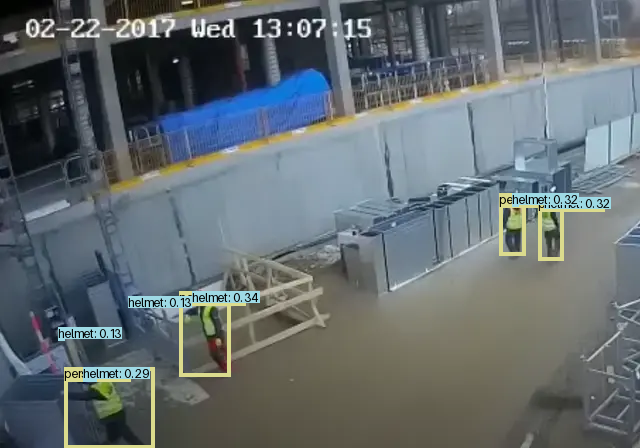

{'people_with_helmets': 4, 'people_without_helmets': 0}


{'people_with_helmets': 4, 'people_without_helmets': 0}

In [ ]:
# Run the test function
test_detect_and_draw()